# Data Processing of Accelerometer Data
This notebook arranged for extracting and processing accelerometer data, especially from Piezotronic (National Instruments) and Digiducer devices. This notebook is arranged as the following work order
1. Extract acceleration data from the obtained measurement file
2. Interpret acceleration data in both time and frequency domain 
3. Convert the acceleration data into velocity and diplacement units
4. Evalute all vibrations data based on defined standard 

### Pre processing step
All necessary library are imported 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tkinter import filedialog as fd
from scipy.signal import argrelextrema, find_peaks
from additional_functions import *

### Working on Digiducer Data
This section focused on extracting and processing data form Digiducer sensor

#### 1. Extract and visualize data from digiducer data (full sequences)

Data extracted from selected file
The data was successfully loaded


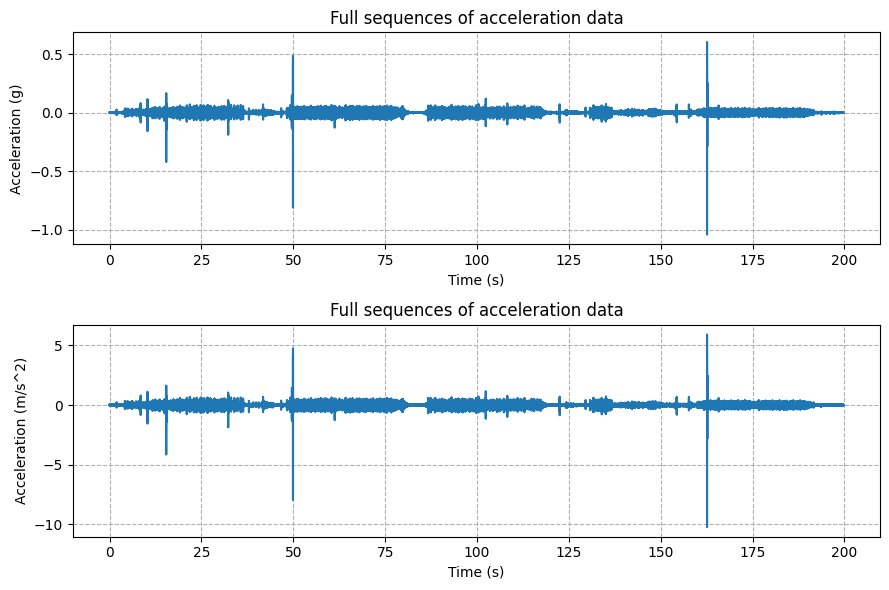

In [4]:
# extract digiducer data
time, accA, accB = extract_digiducer()
print("The data was successfully loaded")

# time based plot of full sequences of loaded data
fig1 = plt.figure(figsize=(9,6), tight_layout=True)
ax1 = fig1.add_subplot(211)
ax1.set_facecolor('white')
ax1.grid(True,which='both',ls='--')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (g)")
ax1.set_title("Full sequences of acceleration data")
line1, = ax1.plot(time, accB)

# Convert acceleration data units from g into m/s^2
g_converter = 9.80665   # a constant, 1 g ~ 9.80665 m/s^2 
accA = accA * g_converter
accB = accB * g_converter

# Plot the acceleration data (in m/s^2 unit)
ax2 = fig1.add_subplot(212)
ax2.set_facecolor('white')
ax2.grid(True,which='both',ls='--')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Acceleration (m/s^2)")
ax2.set_title("Full sequences of acceleration data")
line2, = ax2.plot(time, accB)



#### 2a. Segmenting the acceleration data on each frequencies stimulus (on time domain) and visualizing it

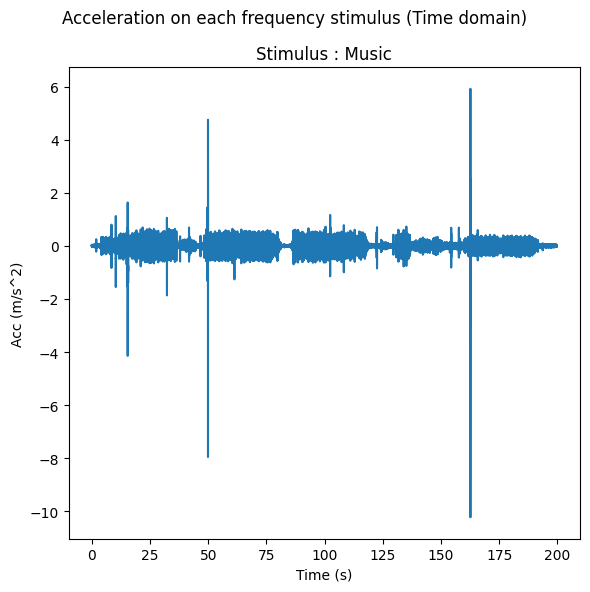

In [9]:
# Segmenting the data for each sequence of stimulus (pure tones having frequencies of 31.5; 40; 50; and 63 Hz)
digiducer_fs = 8000
freq_stimulus = ["Music"]
datapoints = [
    [0*digiducer_fs, 200*digiducer_fs],
    ]

segmented_data = segmenting_data(accB, datapoints)

# interpret acceleration in time domain data for each frequencies
fig2 = plt.figure(figsize=(6,6), tight_layout=True)
fig2.suptitle("Acceleration on each frequency stimulus (Time domain)")
for i in range(len(datapoints)):
    fig2.add_subplot(len(datapoints),1,i+1)
    plt.plot(time[datapoints[i][0]:datapoints[i][1]], segmented_data[i])
    plt.xlabel("Time (s)")
    plt.ylabel("Acc (m/s^2)")
    plt.title("Stimulus : " + freq_stimulus[i])

plt.show()


#### 2b. Transforming the obtained data to frequency domain using FFT

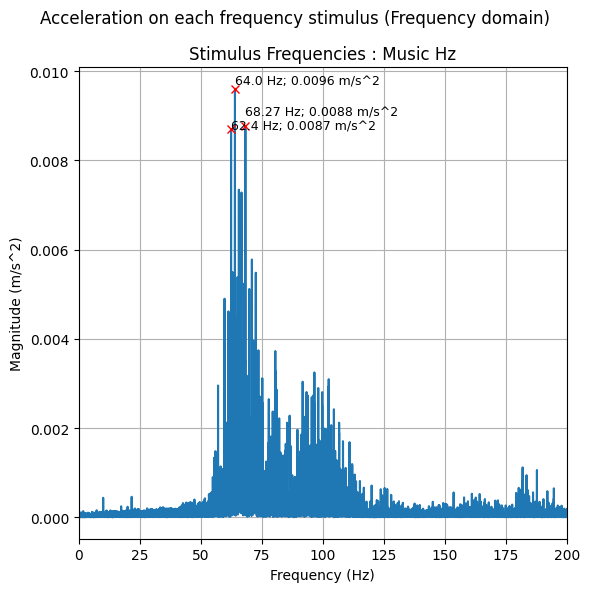

In [71]:
## Tranforming segmented data to frequency domain using Fast-Fourier Transform
fig3 = plt.figure(figsize=(6,6), tight_layout=True)
fig3.suptitle("Acceleration on each frequency stimulus (Frequency domain)")
for i in range(len(datapoints)):
    fig3.add_subplot(len(datapoints),1,i+1)
    
    # applying FFT
    acc = segmented_data[i]
    nfft = int(pow(2, np.ceil(np.log2(len(acc)))))
    win = np.hamming(len(acc))
    freq = (digiducer_fs/2) * np.arange(0,1,1/(nfft/2+1))

    ACC = 2/len(acc) * np.fft.fft(win*acc, nfft)

    data = abs(ACC)[0:int(nfft/2+1)]
    plt.plot(freq, data)

    peaks, _ = find_peaks(data, height=0.008, distance=50)
    plt.plot(freq[peaks], data[peaks], 'rx')

    trunkx = 0
    trunky = 0
    for x, y in zip(np.round(freq_data[peaks],2), np.round(data[peaks],4)):
        #plt.annotate(str(y) + " m/s^2", xy=(x+3,y-0.05), fontsize=9)
        plt.annotate(str(x) + " Hz; " + str(y) + " m/s^2", xy=(x-trunkx,y+trunky), fontsize=9)
        trunkx = trunkx + 0.001
        if y+1 > y:
            trunky = trunky + 0.0001
        else:
            trunky = trunky - 0.0001
    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (m/s^2)")
    
    plt.xlim([0, 200])
    plt.title("Stimulus Frequencies : " + freq_stimulus[i] + " Hz")
    plt.grid(True, which='both')

plt.show()

#### 3a. Convert the acceleration data into velocity units
Converting data carried out by applying omega arithmatic algorithm, which integrating acceleration data to upper level on frequency domain. The detailed information about the algorithm and its application can be seen [here](http://prosig.com/wp-content/uploads/pdf/blogArticles/OmegaArithmetic.pdf).

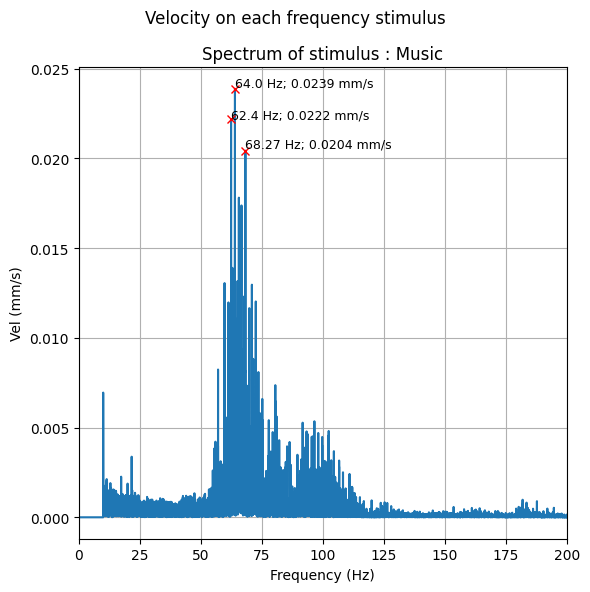

In [70]:
# Convert each acceleration (segmented) data into velocity units
vel = []
cf_frequency = 10

fig4 = plt.figure(figsize=(6,6), tight_layout=True)
fig4.suptitle("Velocity on each frequency stimulus")

for i in range(len(segmented_data)):
    fig4.add_subplot(len(segmented_data),1,i+1)
    vel_data, VEL_data, _, _, freq_data = convert_units(segmented_data[i], digiducer_fs, cf_frequency)
    vel.append(vel_data)

    # fig4.add_subplot(len(segmented_data), 2, 2*i+1)
    # plt.plot(time[datapoints[i][0]:datapoints[i][1]], vel_data*1e3)
    # plt.xlabel("Time (s)")
    # plt.ylabel("Vel (mm/s)")
    # plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

    # fig4.add_subplot(len(segmented_data), 2, 2*(i+1))
    data = abs(VEL_data)[0:int(nfft/2+1)]*1e3
    plt.plot(freq_data, data)

    peaks, _ = find_peaks(data, height=0.02, distance=100)
    plt.plot(freq_data[peaks], data[peaks], 'rx')

    trunkx = 0
    trunky = 0
    for x, y in zip(np.round(freq_data[peaks],2), np.round(data[peaks],4)):
        #plt.annotate(str(y) + " mm/s", xy=(x+3,y-0.05), fontsize=9)
        plt.annotate(str(x) + " Hz; " + str(y) + " mm/s", xy=(x-trunkx,y+trunky), fontsize=9)
        trunkx = trunkx + 0.001
        if y+1 > y:
            trunky = trunky + 0.0001
        else:
            trunky = trunky - 0.0001

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Vel (mm/s)")
    plt.xlim([0, 200])
    plt.title("Spectrum of stimulus : " + freq_stimulus[i])
    plt.grid(True, which='both')
    

#### 3b. Convert the acceleration data into displacement units

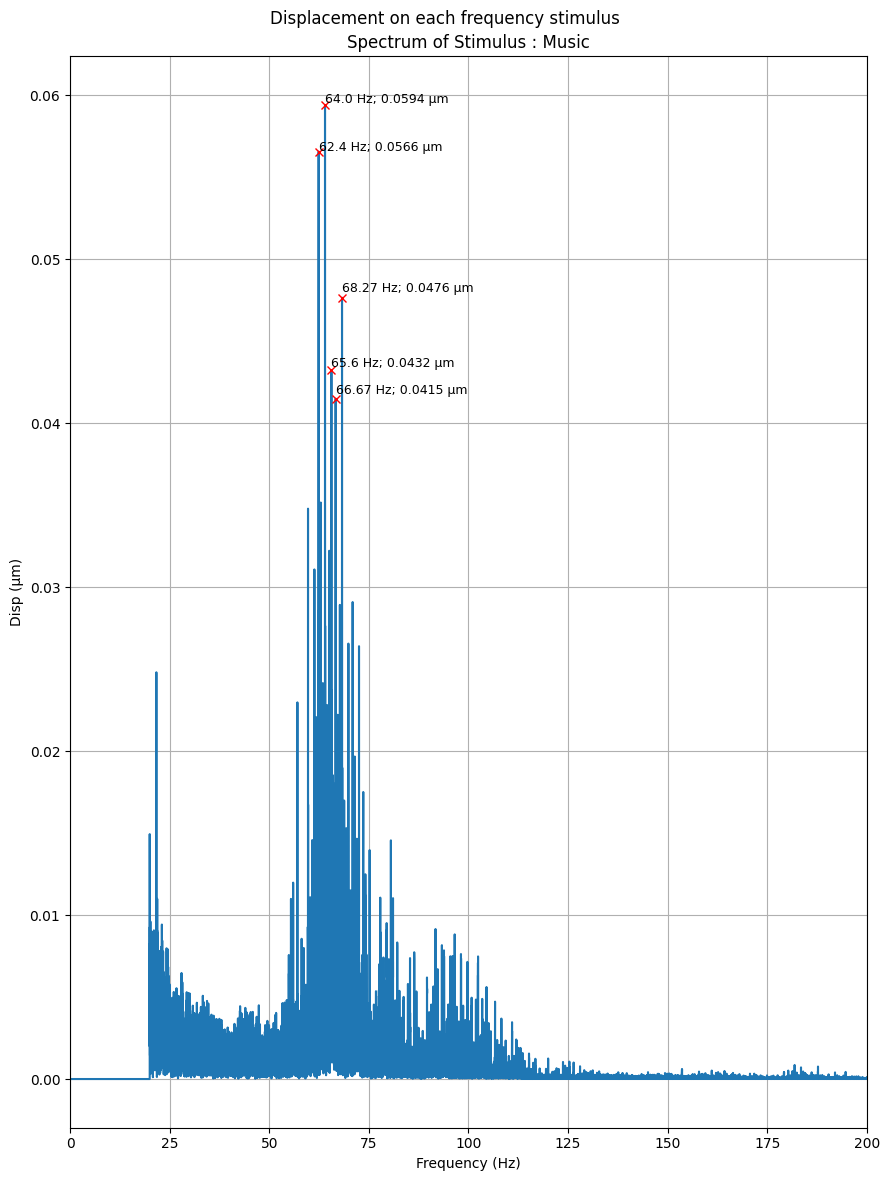

In [83]:
# Convert each velocity (segmented) data into displacement units
disp = []
cf_frequency = 20

fig5 = plt.figure(figsize=(9,12), tight_layout=True)
fig5.suptitle("Displacement on each frequency stimulus")

for i in range(len(segmented_data)):
    fig5.add_subplot(len(segmented_data),1,i+1)
    _, _, disp_data, DISP_data, freq_data = convert_units(segmented_data[i], digiducer_fs, cf_frequency)
    disp.append(disp_data)

    # fig5.add_subplot(len(segmented_data), 2, 2*i+1)
    # plt.plot(time[datapoints[i][0]:datapoints[i][1]], disp_data*1e6)
    # plt.xlabel("Time (s)")
    # plt.ylabel("Disp ($\mu$m)")
    # plt.title("Waveform of Stimulus Frequencies : " + freq_stimulus[i] + " Hz")

    # fig5.add_subplot(len(segmented_data), 2, 2*(i+1))
    data = abs(DISP_data)[0:int(nfft/2+1)]*1e6
    plt.plot(freq_data, data)

    peaks, _ = find_peaks(data, height=0.04, distance=50)
    plt.plot(freq_data[peaks], data[peaks], 'rx')
    
    trunkx = 0
    trunky = 0
    freq_plot = []
    disp_plot = []
    for x, y in zip(np.round(freq_data[peaks],2), np.round(data[peaks],4)):
        #plt.annotate(str(y) + " mm/s", xy=(x+3,y-0.05), fontsize=9)
        plt.annotate(str(x) + " Hz; " + str(y) + " μm", xy=(x-trunkx,y+trunky), fontsize=9)
        freq_plot.append(x)
        disp_plot.append(y)
        trunkx = trunkx + 0.001
        if y+1 > y:
            trunky = trunky + 0.0001
        else:
            trunky = trunky - 0.0001

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Disp (μm)")
    plt.xlim([0, 200])
    plt.title("Spectrum of Stimulus : " + freq_stimulus[i])
    plt.grid(True, which='both')



In [95]:
print(freq_plot)
print(disp_plot)

[62.4, 64.0, 65.6, 66.67, 68.27]
[0.0566, 0.0594, 0.0432, 0.0415, 0.0476]


#### 4. Evaluate the obtained results based on vibration standard

In [77]:
# Obtain RMS, Peak to Peak, and Peak Value of acceleration units
rms_acc = []
pp_acc = []
peak_acc = []
for i in range(len(segmented_data)):
    rms = np.sqrt(np.mean(segmented_data[i]**2))
    rms_acc.append(rms)

    pp = max(segmented_data[i]) - min(segmented_data[i])
    pp_acc.append(pp)

    peak = max(abs(segmented_data[i]))
    peak_acc.append(peak)

    print("Acceration at " + freq_stimulus[i] + " Stimulus has RMS = " + str(round(rms,3)) + " m/s^2, Peak to Peak = " + str(round(pp,3)) + " m/s^2, Peak = " + str(round(peak,3)) + " m/s^2")

Acceration at Music Stimulus has RMS = 0.096 m/s^2, Peak to Peak = 16.145 m/s^2, Peak = 10.226 m/s^2


In [78]:
# Obtain RMS, Peak to Peak, and Peak Value of velocity units
rms_vel = []
pp_vel = []
peak_vel = []
for i in range(len(vel)):
    rms = np.sqrt(np.mean(np.real(vel[i]*1e3)**2))
    rms_vel.append(rms)

    pp = max(np.real(vel[i]*1e3)) - min(np.real(vel[i]*1e3))
    pp_vel.append(pp)

    peak = max(abs(np.real(vel[i]*1e3)))
    peak_vel.append(peak)

    print("Velocity at " + freq_stimulus[i] + " Stimulus has RMS = " + str(round(rms,3)) + " mm/s, Peak to Peak = " + str(round(pp,3)) + " mm/s, Peak = " + str(round(peak,3)) + " mm/s")

Velocity at Music Stimulus has RMS = 0.196 mm/s, Peak to Peak = 9.151 mm/s, Peak = 5.697 mm/s


In [79]:
# Obtain RMS, Peak to Peak, and Peak Value of displacement units
rms_disp = []
pp_disp = []
peak_disp = []
for i in range(len(disp)):
    rms = np.sqrt(np.mean(np.real(disp[i]*1e6)**2))
    rms_disp.append(rms)
    
    pp = max(np.real(disp[i]*1e6)) - min(np.real(disp[i]*1e6))
    pp_disp.append(pp)

    peak = max(abs(np.real(disp[i]*1e6)))
    peak_disp.append(peak)

    print("Displacement at " + freq_stimulus[i] + " Stimulus has RMS = " + str(round(rms,3)) + " μm, Peak to Peak = " + str(round(pp,3)) + " μm, Peak = " + str(round(peak,3)) + " μm")

Displacement at Music Stimulus has RMS = 0.529 μm, Peak to Peak = 33.503 μm, Peak = 20.65 μm


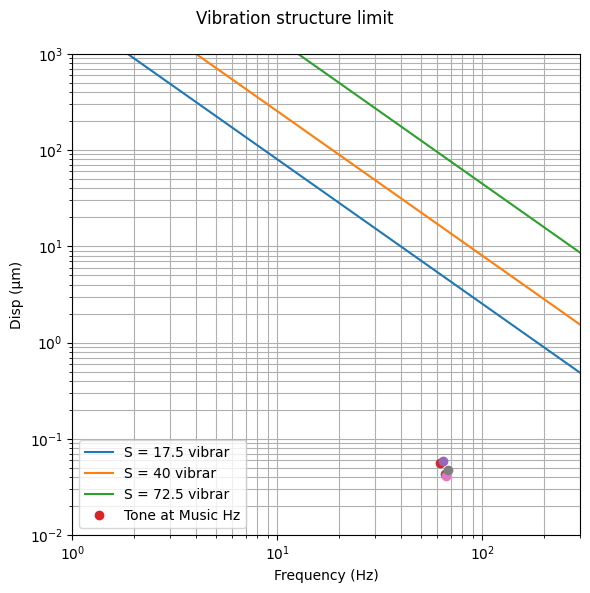

In [102]:
# Interpret the displacement result on graph (on progress)
vib_limit = [6.4, 64, 2000]    # limits on mm^2 / s^3
legend_limit = ["S = 17.5 vibrar", "S = 40 vibrar", "S = 72.5 vibrar"]
freq_limit = np.linspace(1, 1000, 1000)

disp_limit = [0.0566, 0.0594, 0.0432, 0.0415, 0.0476]

fig5 = plt.figure(figsize=(6,6), tight_layout=True)
fig5.suptitle("Vibration structure limit")

line_lim = []
for i in range(len(vib_limit)):
    data = []
    for f in range(len(freq_limit)):
        x = np.sqrt(vib_limit[i] / (pow(freq_limit[f],3)) )
        x = x*1e3   # Change displacement units from mm into micron
        data.append(x)
    line_lim.append(data)
    plt.plot(freq_limit, data)

    plt.yscale('log')
    plt.ylim([0.01, 1000])
    plt.ylabel("Disp (μm)")
    plt.xscale('log')
    plt.xlim([1, 300])
    plt.xlabel("Frequency (Hz)")
    
# plot displacement from measured result

for i in range(len(disp_limit)):
    plt.plot((freq_plot[i]), disp_limit[i], 'o')

legend_data = [str("Tone at " + freq_stimulus[i] + " Hz") for i in range(len(freq_stimulus))]

plt.legend(legend_limit + legend_data)
plt.grid(True, which='both')
